In [1]:
%matplotlib inline

import os
import numpy as np 
import pandas as pd
from glob import glob

USE_CV2 = False
if USE_CV2:
    from cv2 import imread # opencv is much faster, but less accurate
else:
    from skimage.io import imread

import matplotlib.pyplot as plt

from skimage.segmentation import mark_boundaries
from skimage.transform import resize

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dropout, Conv2D, Cropping2D, Conv2DTranspose, Add, Input, Reshape, Permute, Activation

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Data path used in this notebook. 

DATA_DIR = os.path.join('.', 'data')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'Train/CameraRGB')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'Train/CameraSeg')

clara_seg_data = pd.DataFrame(dict(image = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*p*g'))))
clara_seg_data['id'] = clara_seg_data['image'].map(lambda x: x.split('/')[-1].split('.')[0])
clara_seg_data['label'] = clara_seg_data['image'].map(lambda x: os.path.join(TRAIN_LABEL_DIR, x.split('/')[-1]))
clara_seg_data.sample(5)

,image,id,label
860,./data/Train/CameraRGB/89.png,89,./data/Train/CameraSeg/89.png
764,./data/Train/CameraRGB/261.png,261,./data/Train/CameraSeg/261.png
409,./data/Train/CameraRGB/52.png,52,./data/Train/CameraSeg/52.png
505,./data/Train/CameraRGB/262.png,262,./data/Train/CameraSeg/262.png
884,./data/Train/CameraRGB/422.png,422,./data/Train/CameraSeg/422.png


## Exploring the Dataset

In [3]:
print ("Total number of examples {}".format(clara_seg_data.shape[0]))
print ("Dimensions of input image {}".format(imread(clara_seg_data.sample(1)['image'].values[0]).shape))
print ("Total labels {} ".format(len(np.unique(imread(clara_seg_data.sample(1)['label'].values[0])[:, :, 0]))))

Total number of examples 1000
Dimensions of input image (600, 800, 3)
Total labels 12 


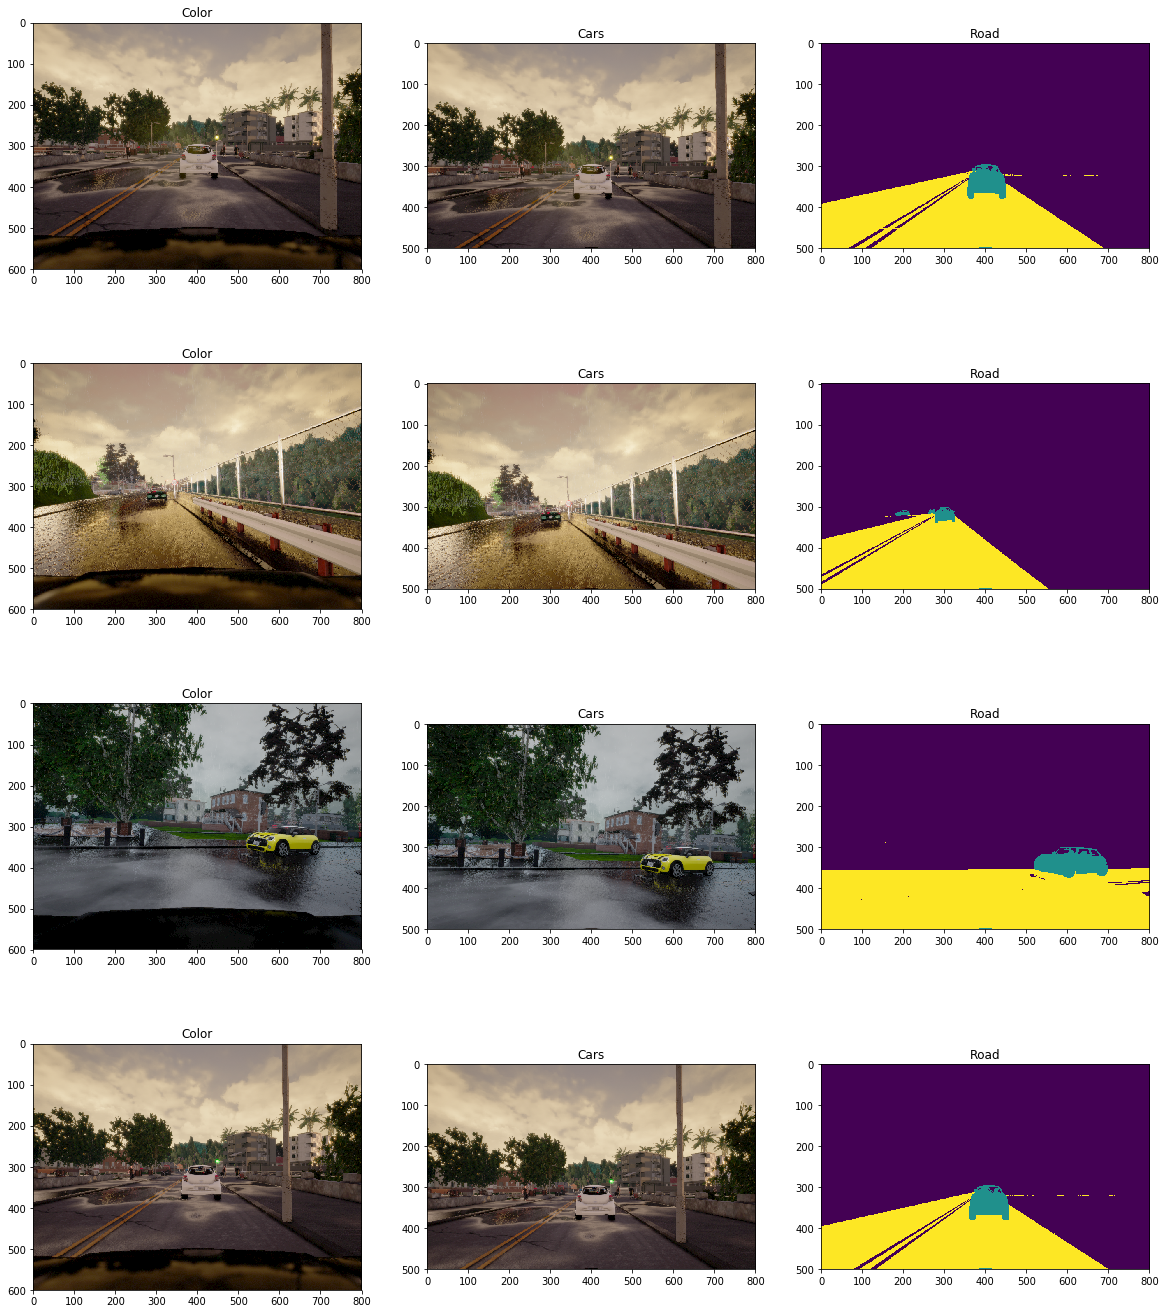

In [4]:
### print(clara_seg_data.shape[0], 'rows')
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, clara_seg_data.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])
    
    c_img2 = c_img[:500, :, :]
    l_img = imread(c_row['label'])
    l_img = l_img[:500, :, 0]
    
    lbls = np.zeros_like(l_img)
    lbls[l_img == 10] = 1
    lbls[l_img == 7] = 2
    
    ax1.imshow(c_img)
    ax1.set_title('Color')    
    ax2.imshow(c_img2)
    ax2.set_title('Cars')
    ax3.imshow(lbls)
    ax3.set_title('Road')

In [67]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(480, 480, 3))

for layer in base_model.layers:
    layer.trainable = False

nClasses = 3

block3_pool = base_model.get_layer('block3_pool').output
block4_pool = base_model.get_layer('block4_pool').output
block5_pool = base_model.get_layer('block5_pool').output

conv_name_base = "block%d_conv%d"
pool_name_base = "block%d_pool"
dropout_name_base = "block%d_dropout"

block = 6
step = 1

X = Conv2D(4096, (7, 7),  padding='same', activation='relu', name='block6_conv1')(block5_pool)
X = Dropout(0.5, name='block6_dropout1')(X)
X = Conv2D(4096, (1, 1), activation='relu', padding='same', name='block6_conv2')(X)
X = Dropout(0.5, name='block6_dropout2')(X)
X = Conv2D(nClasses, (1, 1), padding='same', kernel_initializer='he_normal', name='block6_conv3')(X)
X = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(2,2) , padding='same', use_bias=False, name='block6_deconv1')(X)

X2 = Conv2D(nClasses, (1, 1), kernel_initializer='he_normal', padding='same', name='block7_conv1')(block4_pool)
# X2 = Cropping2D(cropping=((0, 1), (0, 0)))(X2)
X = Add(name='block7_Add')([X, X2])
X = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(2, 2), padding='same')(X)

X3 = Conv2D(nClasses, (1, 1), padding='same', name='block8_conv1')(block3_pool)
# X3 = Cropping2D(cropping=((0, 3), (0, 0)))(X3)
X = Add(name='block8_Add')([X, X3])
X = Conv2DTranspose(nClasses, kernel_size=(16, 16), strides=(8, 8), padding='same', name='block8_Deconv')(X)

X = (Reshape((-1, nClasses)))(X)
X = (Activation('softmax'))(X)

model = Model(base_model.input, X)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [68]:
model.compile(loss='categorical_crossentropy',
      optimizer= 'adam' ,
      metrics=['accuracy'])

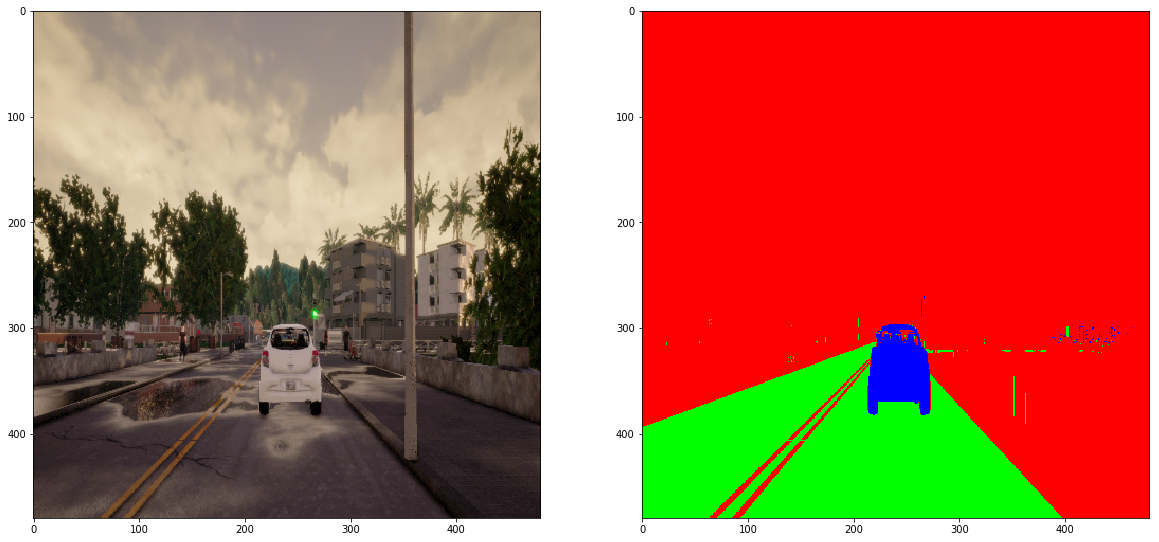

In [76]:
import cv2 

height   = 480
width    = 480
nClasses = 3

sample = clara_seg_data.sample(1)
X_input = imread(sample['image'].values[0])
Y_input = imread(sample['label'].values[0])

X_train = X_input[:480, :, :]
X_train = cv2.resize(X_train, (480, 480))

y_tmp = Y_input[:480, :, 0]
y_tmp = cv2.resize(y_tmp, (480, 480))

Y_train = np.zeros(( height , width  , nClasses ))    
Y_train[:, :, 2] = (y_tmp== 10).astype(int)
Y_train[:, :, 1] = (y_tmp== 7).astype(int)
Y_train[:, :, 0] = ~((y_tmp == 7) | (y_tmp == 10))

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(X_train)
plt.subplot(122)
plt.imshow(Y_train)


In [77]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

X_train = image.img_to_array(X_train)
X_train = np.expand_dims(X_train, axis=0)
X_train = preprocess_input(X_train)

# Y_train = cv2.resize(Y_train, (576, 800))
Y_train = np.reshape(Y_train, (-1 , nClasses ))
Y_train = np.expand_dims(Y_train, axis=0)

print (X_train.shape)
print (Y_train.shape)

(1, 480, 480, 3)
(1, 230400, 3)


In [78]:
model.reset_states()
history = model.fit(X_train, Y_train, epochs=250)

Epoch 1/250
1/1 [==============================] - 0s 172ms/step - loss: 1.4419 - acc: 0.9103
Epoch 2/250
1/1 [==============================] - 0s 168ms/step - loss: 1.0071 - acc: 0.9371
Epoch 3/250
1/1 [==============================] - 0s 166ms/step - loss: 0.7346 - acc: 0.9542
Epoch 4/250
1/1 [==============================] - 0s 164ms/step - loss: 0.6674 - acc: 0.9584
Epoch 5/250
1/1 [==============================] - 0s 164ms/step - loss: 0.6429 - acc: 0.9600
Epoch 6/250
1/1 [==============================] - 0s 165ms/step - loss: 0.6432 - acc: 0.9600
Epoch 7/250
1/1 [==============================] - 0s 166ms/step - loss: 0.6316 - acc: 0.9607
Epoch 8/250
1/1 [==============================] - 0s 165ms/step - loss: 0.6143 - acc: 0.9618
Epoch 9/250
1/1 [==============================] - 0s 163ms/step - loss: 0.6241 - acc: 0.9612
Epoch 10/250
1/1 [==============================] - 0s 166ms/step - loss: 0.5674 - acc: 0.9647
Epoch 11/250
1/1 [==============================] - 0s 165m

Epoch 88/250
1/1 [==============================] - 0s 164ms/step - loss: 0.4505 - acc: 0.9720
Epoch 89/250
1/1 [==============================] - 0s 163ms/step - loss: 0.4491 - acc: 0.9721
Epoch 90/250
1/1 [==============================] - 0s 162ms/step - loss: 0.4489 - acc: 0.9721
Epoch 91/250
1/1 [==============================] - 0s 163ms/step - loss: 0.4479 - acc: 0.9722
Epoch 92/250
1/1 [==============================] - 0s 164ms/step - loss: 0.4448 - acc: 0.9724
Epoch 93/250
1/1 [==============================] - 0s 165ms/step - loss: 0.4485 - acc: 0.9721
Epoch 94/250
1/1 [==============================] - 0s 165ms/step - loss: 0.4456 - acc: 0.9723
Epoch 95/250
1/1 [==============================] - 0s 163ms/step - loss: 0.4427 - acc: 0.9725
Epoch 96/250
1/1 [==============================] - 0s 161ms/step - loss: 0.4431 - acc: 0.9725
Epoch 97/250
1/1 [==============================] - 0s 163ms/step - loss: 0.4615 - acc: 0.9713
Epoch 98/250
1/1 [==============================] 

Epoch 174/250
1/1 [==============================] - 0s 166ms/step - loss: 0.4424 - acc: 0.9725
Epoch 175/250
1/1 [==============================] - 0s 165ms/step - loss: 0.4471 - acc: 0.9722
Epoch 176/250
1/1 [==============================] - 0s 163ms/step - loss: 0.4382 - acc: 0.9728
Epoch 177/250
1/1 [==============================] - 0s 165ms/step - loss: 0.4370 - acc: 0.9728
Epoch 178/250
1/1 [==============================] - 0s 165ms/step - loss: 0.4358 - acc: 0.9729
Epoch 179/250
1/1 [==============================] - 0s 166ms/step - loss: 0.4388 - acc: 0.9727
Epoch 180/250
1/1 [==============================] - 0s 164ms/step - loss: 0.4411 - acc: 0.9726
Epoch 181/250
1/1 [==============================] - 0s 166ms/step - loss: 0.4338 - acc: 0.9731
Epoch 182/250
1/1 [==============================] - 0s 168ms/step - loss: 0.4442 - acc: 0.9724
Epoch 183/250
1/1 [==============================] - 0s 166ms/step - loss: 0.4429 - acc: 0.9725
Epoch 184/250
1/1 [=====================

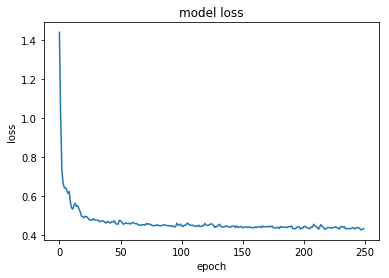

In [79]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
X_input_test = image.img_to_array(X_input)
X_input_test = cv2.resize(X_input_test, (480, 480))
X_input_test = np.expand_dims(X_input_test, axis=0)
X_input_test = preprocess_input(X_input_test)
Y_pred = model.predict(X_input_test)

In [82]:
print (Y_pred.shape)

(1, 230400, 3)


In [83]:
Y_pred = Y_pred.reshape((480, 480, 3)).argmax(axis=2)
print (Y_pred.shape)
print (np.unique(Y_pred))

(480, 480)
[0 1 2]


In [85]:
y_pred_color = np.zeros( (480, 480, 3))
y_pred_color[:, :, 0]  = Y_pred == 0
y_pred_color[:, :, 1]  = Y_pred == 1
y_pred_color[:, :, 2]  = Y_pred == 2

y_pred_color = cv2.resize(y_pred_color, (800, 600))

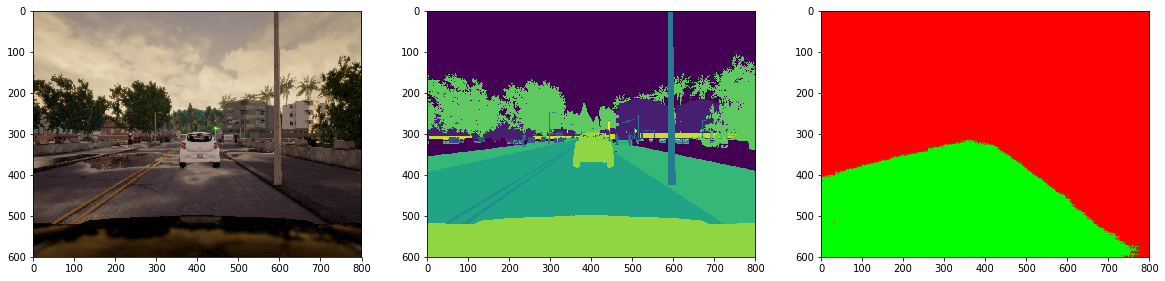

In [86]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(X_input)
plt.subplot(132)
plt.imshow(Y_input[:, :, 0])
plt.subplot(133)
plt.imshow(y_pred_color)